In [86]:
from os import listdir
from os.path import isfile, join
import math
import pandas as pd
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [87]:
root_dir = './results_backup/three_results/'

results=[]
for f in listdir(root_dir):
    path = join(root_dir, f)
    if isfile(path):
        fo = open(path)
        jso = json.loads(fo.read())
        splt = f.split('_')
        tmpvm = splt[3] if len(splt) == 5 else splt[3] + '_' + splt[4]
        if tmpvm.startswith('openj9'):
                vm = 'openj9'
        elif tmpvm.startswith('hotspot'):
                vm = 'hotspot'
        elif tmpvm.startswith('graalvm-ce'):
                vm = 'graalvm CE'
        else:
                vm = 'graalvm EE'
        if '11' in tmpvm:
                vm_version = 11
        elif '12' in tmpvm:
                vm_version = 12
        else:
                vm_version = 8
        timestamp = splt[-1][:-5]
        pattern = splt[1]
        program = splt[2]
        language = splt[0]
        for (idx, time) in enumerate(jso[0]['primaryMetric']['rawData'][0]):
                results.append({
                        'vm': vm,
                        'vm_version': str(vm_version),
                        'vm_full': vm + ' ' + str(vm_version),
                        'pattern': pattern,
                        'program': language[0]+"_"+program,
                        'language': language,
                        'timestamp': timestamp,
                        'time': time,
                        'idx': idx
                })

df = pd.DataFrame(results)
df.describe(include='all')

magix_number=272

In [88]:
nwp = df[df['idx']>10]
variances = pd.DataFrame(nwp.groupby(["program", "vm_full", "pattern"]).time.var())
variances["program"] = ""
variances["vm_full"] = ""
variances["pattern"] = ""
variances.program = variances.index.get_level_values(0)
variances.vm_full = variances.index.get_level_values(1)
variances.pattern = variances.index.get_level_values(2)
variances.index = range(magix_number)
variances.rename(columns={"time":"Variance"}, inplace=True)

In [89]:
deviations = pd.DataFrame(nwp.groupby(["program", "vm_full", "pattern"]).time.std())
deviations["program"] = ""
deviations["vm_full"] = ""
deviations["pattern"] = ""
deviations.program = deviations.index.get_level_values(0)
deviations.vm_full = deviations.index.get_level_values(1)
deviations.pattern = deviations.index.get_level_values(2)
deviations.index = range(magix_number)
deviations.rename(columns={"time":"Deviation"}, inplace=True)

In [90]:
means = pd.DataFrame(nwp.groupby(["program", "vm_full", "pattern"]).time.mean())
means["program"] = ""
means["vm_full"] = ""
means["pattern"] = ""
means.program = means.index.get_level_values(0)
means.vm_full = means.index.get_level_values(1)
means.pattern = means.index.get_level_values(2)
means.index = range(magix_number)
means.rename(columns={"time":"Mean"}, inplace=True)

In [91]:
medians = pd.DataFrame(nwp.groupby(["program", "vm_full", "pattern"]).time.median())
medians["program"] = ""
medians["vm_full"] = ""
medians["pattern"] = ""
medians.program = medians.index.get_level_values(0)
medians.vm_full = medians.index.get_level_values(1)
medians.pattern = medians.index.get_level_values(2)
medians.index = range(magix_number)
medians.rename(columns={"time":"Median"}, inplace=True)

In [92]:
stats = pd.concat([means, medians, deviations, variances], axis=1)
stats = stats.loc[:,~stats.columns.duplicated()]
stats

,Mean,program,vm_full,pattern,Median,Deviation,Variance
0,1.465116,b_fibonacci,graalvm CE 8,interpreter,1.521118,0.099140,0.009829
1,1.581500,b_fibonacci,graalvm CE 8,revisitor,1.654115,0.109445,0.011978
2,1.771207,b_fibonacci,graalvm CE 8,switch,1.815975,0.085801,0.007362
3,1.391093,b_fibonacci,graalvm CE 8,truffle,1.458885,0.111984,0.012540
4,1.546396,b_fibonacci,graalvm CE 8,visitor,1.537204,0.015411,0.000237
5,1.194350,b_fibonacci,graalvm EE 8,interpreter,1.150130,0.077125,0.005948
6,1.380259,b_fibonacci,graalvm EE 8,revisitor,1.377325,0.021373,0.000457
7,1.424522,b_fibonacci,graalvm EE 8,switch,1.421949,0.007753,0.000060
8,1.019734,b_fibonacci,graalvm EE 8,truffle,0.975341,0.073341,0.005379
9,1.259191,b_fibonacci,graalvm EE 8,visitor,1.252764,0.017785,0.000316


In [93]:
truffleStats = stats[stats.pattern.isin(["interpreter","truffle"])]
truffleStats = truffleStats[truffleStats.vm_full.isin(["graalvm CE 8","graalvm EE 8"])]
#truffleStats = truffleStats[~truffleStats.program.isin(["m_fannkuchredux","m_sort","m_binarytree"])]
truffleStats.index = range(32)
truffleStats

,Mean,program,vm_full,pattern,Median,Deviation,Variance
0,1.465116,b_fibonacci,graalvm CE 8,interpreter,1.521118,0.099140,0.009829
1,1.391093,b_fibonacci,graalvm CE 8,truffle,1.458885,0.111984,0.012540
2,1.194350,b_fibonacci,graalvm EE 8,interpreter,1.150130,0.077125,0.005948
3,1.019734,b_fibonacci,graalvm EE 8,truffle,0.975341,0.073341,0.005379
4,1.571188,b_sort,graalvm CE 8,interpreter,1.570174,0.008222,0.000068
5,1.593299,b_sort,graalvm CE 8,truffle,1.608176,0.029997,0.000900
6,0.834006,b_sort,graalvm EE 8,interpreter,0.833823,0.004018,0.000016
7,1.071101,b_sort,graalvm EE 8,truffle,1.117914,0.072477,0.005253
8,4.636862,f_buffers,graalvm CE 8,interpreter,4.622185,0.037872,0.001434
9,3.937675,f_buffers,graalvm CE 8,truffle,3.939117,0.055936,0.003129


In [94]:
effectSize = pd.DataFrame(truffleStats)
effectSize["Mean_Effect_Size"] = 0
effectSize["Median_Effect_Size"] = 0
for i in range(32):
  if effectSize.loc[i,"pattern"] == "interpreter":
    SDpooled = math.sqrt((149*effectSize.loc[i+1,"Deviation"]**2+149*effectSize.loc[i,"Deviation"]**2)/298)
    VARpooled = math.sqrt((149*effectSize.loc[i+1,"Variance"]**2+149*effectSize.loc[i,"Variance"]**2)/298)
    
    effectSize.loc[i,"Mean"] = effectSize.loc[i,"Mean"]-effectSize.loc[i+1,"Mean"]
    effectSize.loc[i,"Median"] = effectSize.loc[i,"Median"]-effectSize.loc[i+1,"Median"]
    effectSize.loc[i,"Variance"] = VARpooled
    effectSize.loc[i,"Deviation"] = SDpooled
    effectSize.loc[i,"Mean_Effect_Size"] = effectSize.loc[i,"Mean"] / SDpooled
    effectSize.loc[i,"Median_Effect_Size"] = effectSize.loc[i,"Median"] / SDpooled
    
    effectSize.loc[i+1,"Mean"] = 0
    effectSize.loc[i+1,"Median"] = 0
    effectSize.loc[i+1,"Variance"] = 0
    effectSize.loc[i+1,"Deviation"] = 0
    effectSize.loc[i+1,"Mean_Effect_Size"] = 0
    effectSize.loc[i+1,"Median_Effect_Size"] = 0
    
effectSize = effectSize.groupby(["program", "vm_full"]).sum()
effectSize["program"] = ""
effectSize["vm_full"] = ""
effectSize.program = effectSize.index.get_level_values(0)
effectSize.vm_full = effectSize.index.get_level_values(1)
effectSize.index = range(16)
effectSize.rename(columns={"Mean":"Mean_dist"}, inplace=True)
effectSize.rename(columns={"Median":"Median_dist"}, inplace=True)
effectSize.rename(columns={"Deviation":"Pooled_Deviation"}, inplace=True)
effectSize.rename(columns={"Variance":"Pooled_Variance"}, inplace=True)
effectSize

,Mean_dist,Median_dist,Pooled_Deviation,Pooled_Variance,Mean_Effect_Size,Median_Effect_Size,program,vm_full
0,0.074023,0.062233,0.105757,0.011267,0.699931,0.588453,b_fibonacci,graalvm CE 8
1,0.174616,0.174789,0.075256,0.005671,2.320285,2.322575,b_fibonacci,graalvm EE 8
2,-0.022111,-0.038002,0.021993,0.000638,-1.005341,-1.727885,b_sort,graalvm CE 8
3,-0.237095,-0.284090,0.051328,0.003714,-4.619230,-5.534828,b_sort,graalvm EE 8
4,0.699187,0.683068,0.047766,0.002434,14.637859,14.300402,f_buffers,graalvm CE 8
5,0.225109,0.220521,0.043261,0.002510,5.203509,5.097451,f_buffers,graalvm EE 8
6,-0.178525,-0.172609,0.169272,0.028653,-1.054665,-1.019716,l_fractal,graalvm CE 8
7,-0.040616,-0.076155,0.188708,0.035636,-0.215229,-0.403560,l_fractal,graalvm EE 8
8,0.004296,0.005715,0.031969,0.001220,0.134367,0.178756,m_binarytree,graalvm CE 8
9,0.290755,0.314455,0.056333,0.003178,5.161399,5.582121,m_binarytree,graalvm EE 8


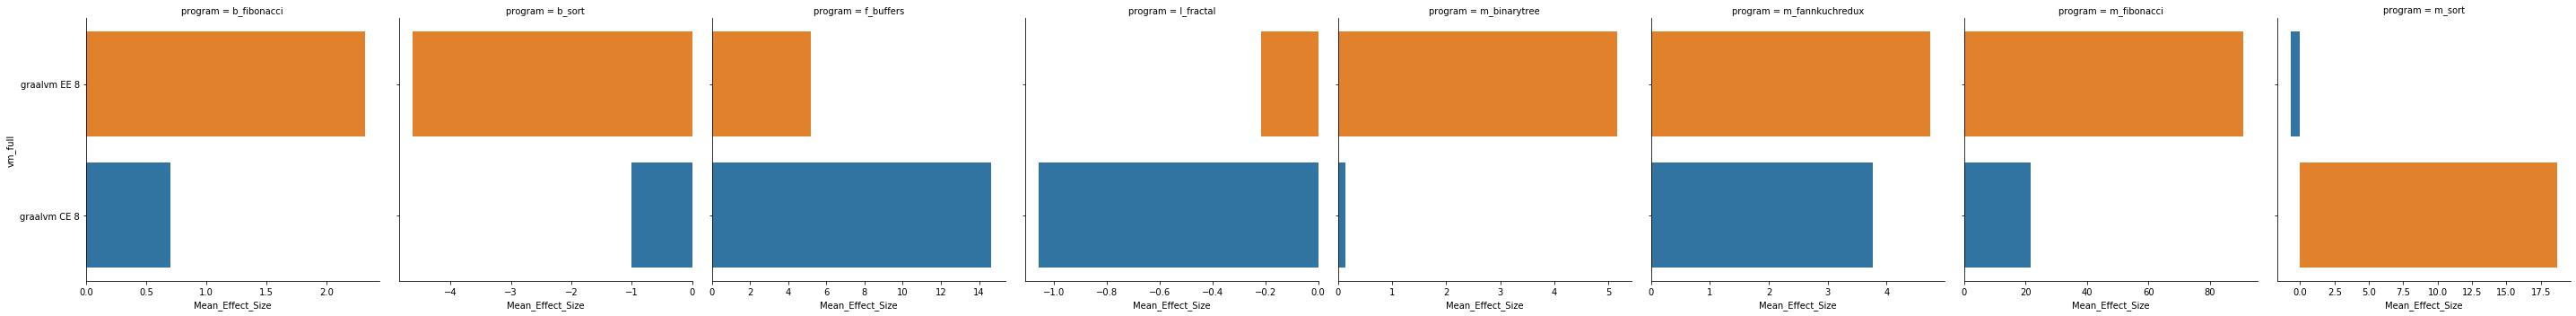

In [95]:
sns.catplot(x="Mean_Effect_Size", y="vm_full", col="program", kind="bar", data=effectSize, sharex=False, legend_out=True)

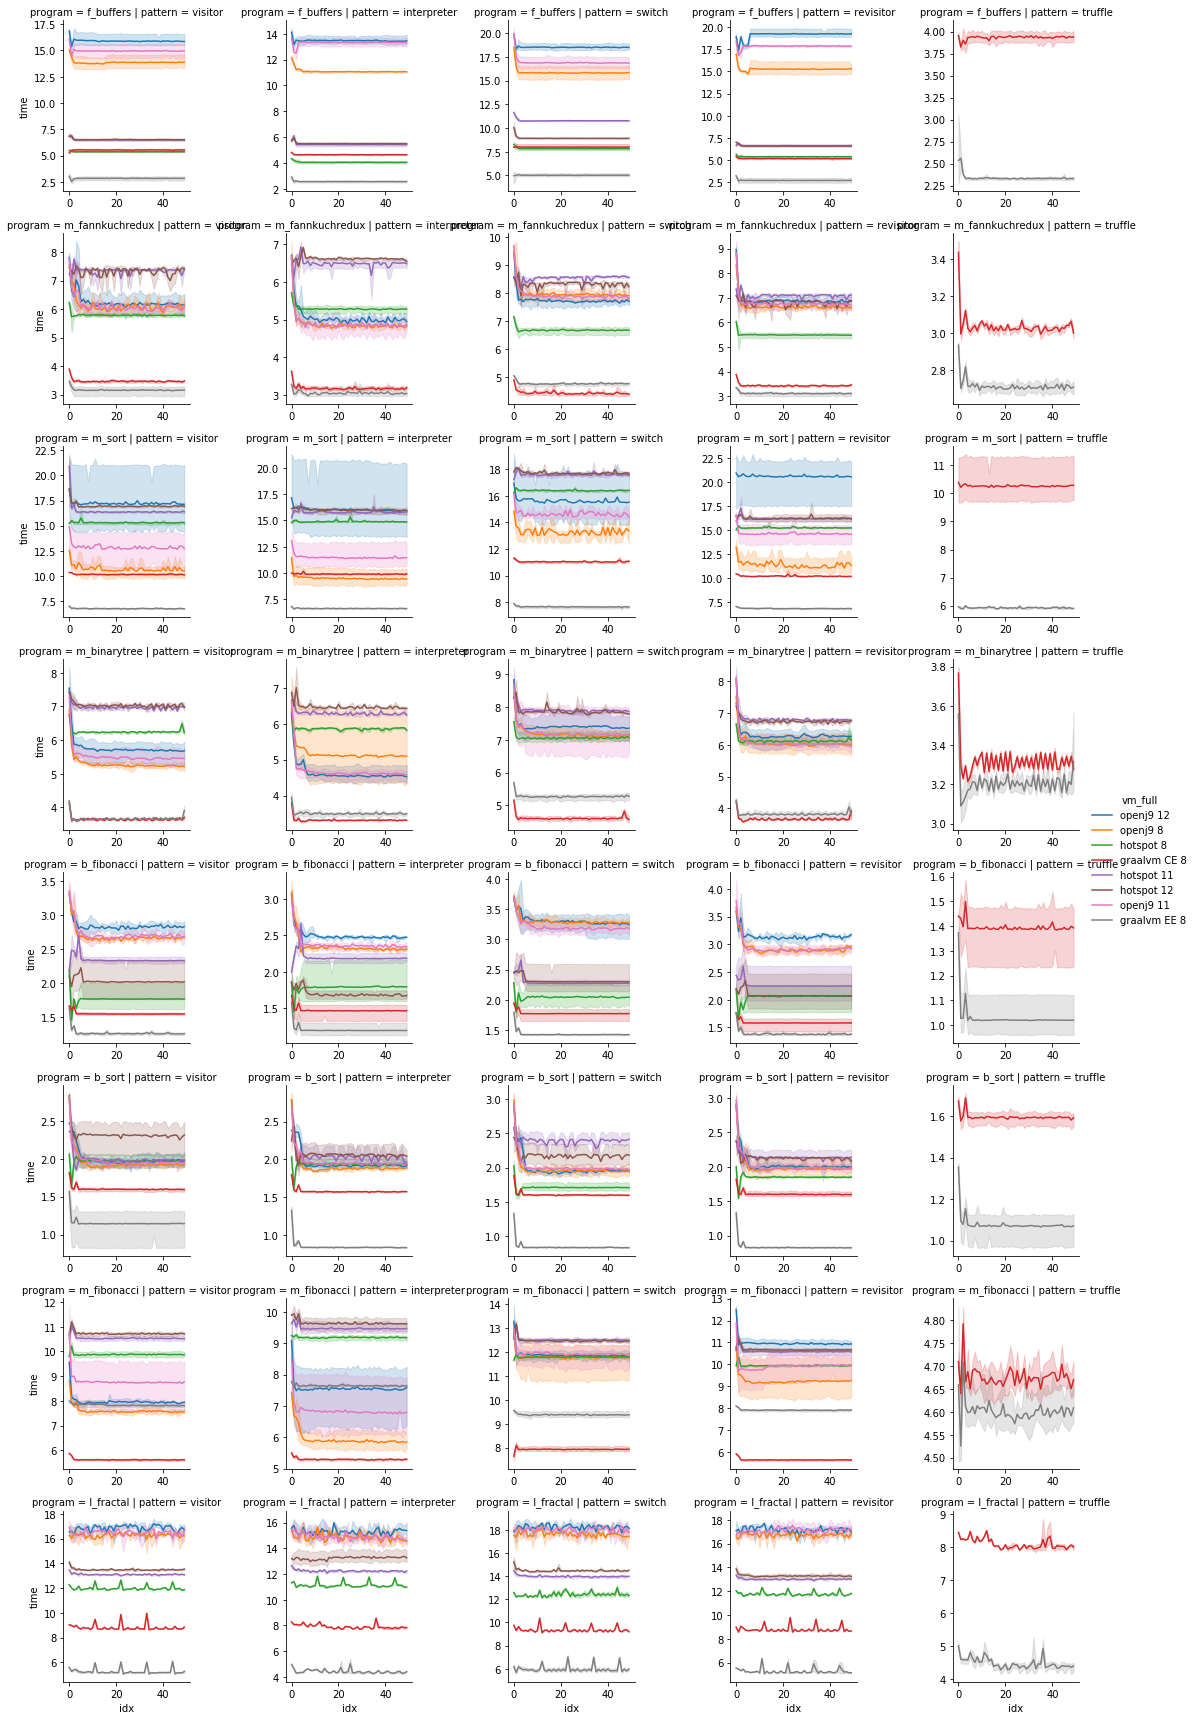

In [96]:
grid = sns.FacetGrid(df, col="pattern", row="program", hue="vm_full", sharex=False, sharey=False)
grid.map(sns.lineplot, "idx", "time").add_legend()

In [97]:
#grid = sns.FacetGrid(df, col="program", row="pattern", hue="vm_full", sharex=False, sharey=False)
#grid.map(sns.lineplot, "idx", "time")

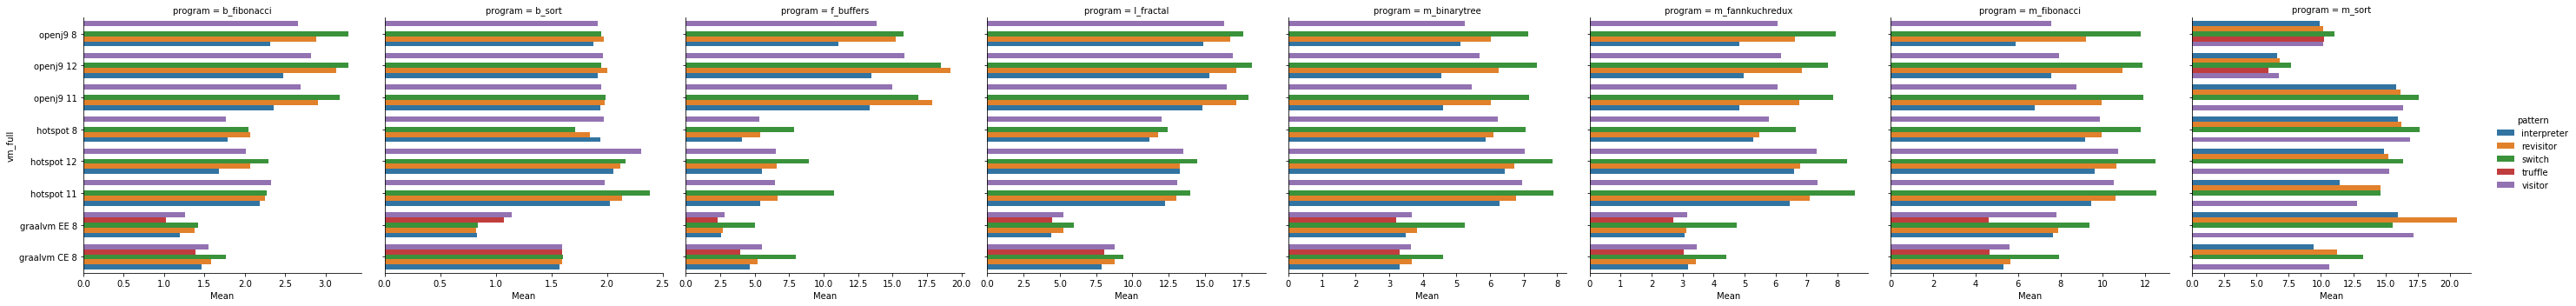

In [98]:
sns.catplot(x="Mean", y="vm_full", col="program", hue="pattern", kind="bar", data=means, sharex=False, legend_out=True)

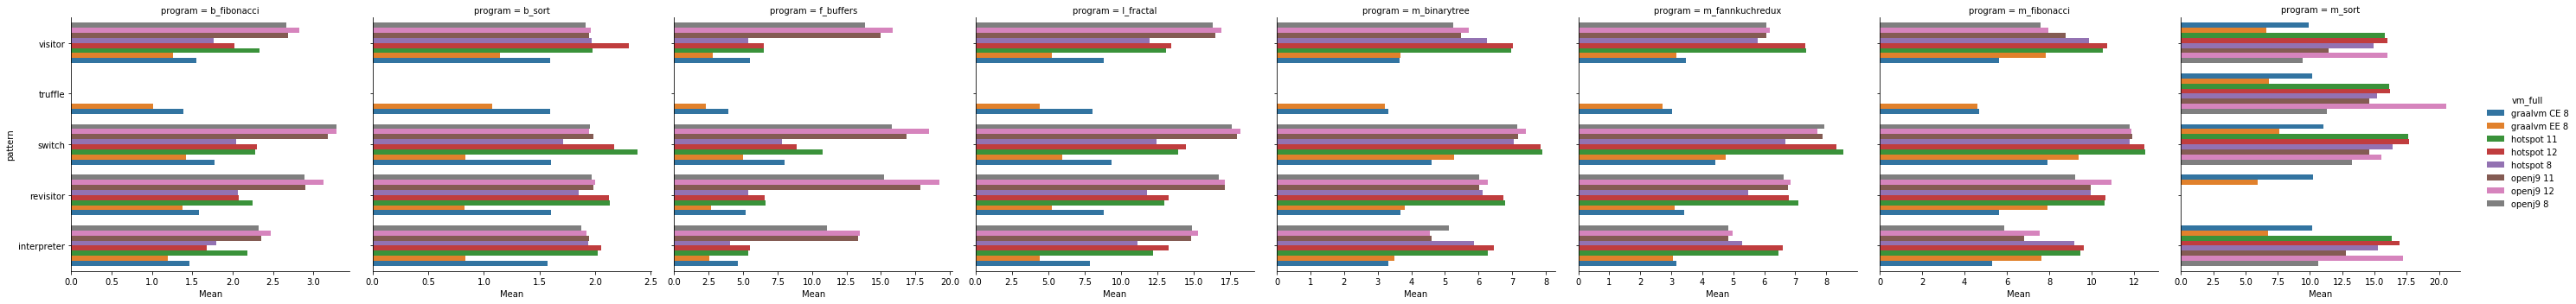

In [99]:
sns.catplot(x="Mean", y="pattern", col="program", hue="vm_full", kind="bar", data=means, sharex=False, legend_out=True)

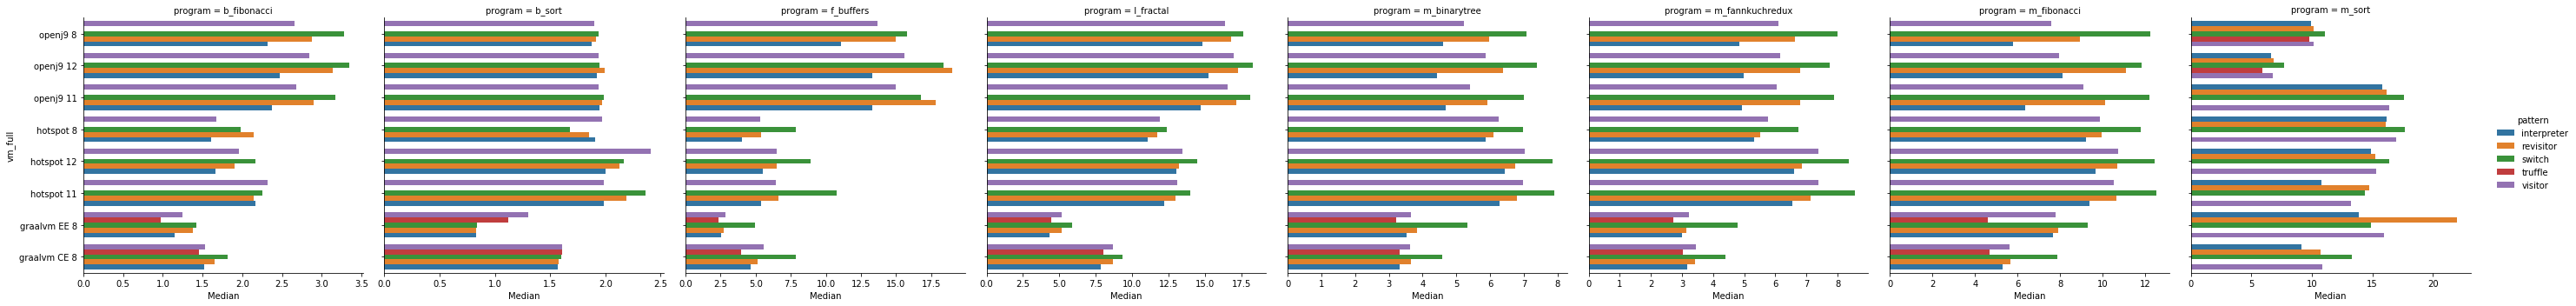

In [100]:
sns.catplot(x="Median", y="vm_full", col="program", hue="pattern", kind="bar", data=medians, sharex=False, legend_out=True)

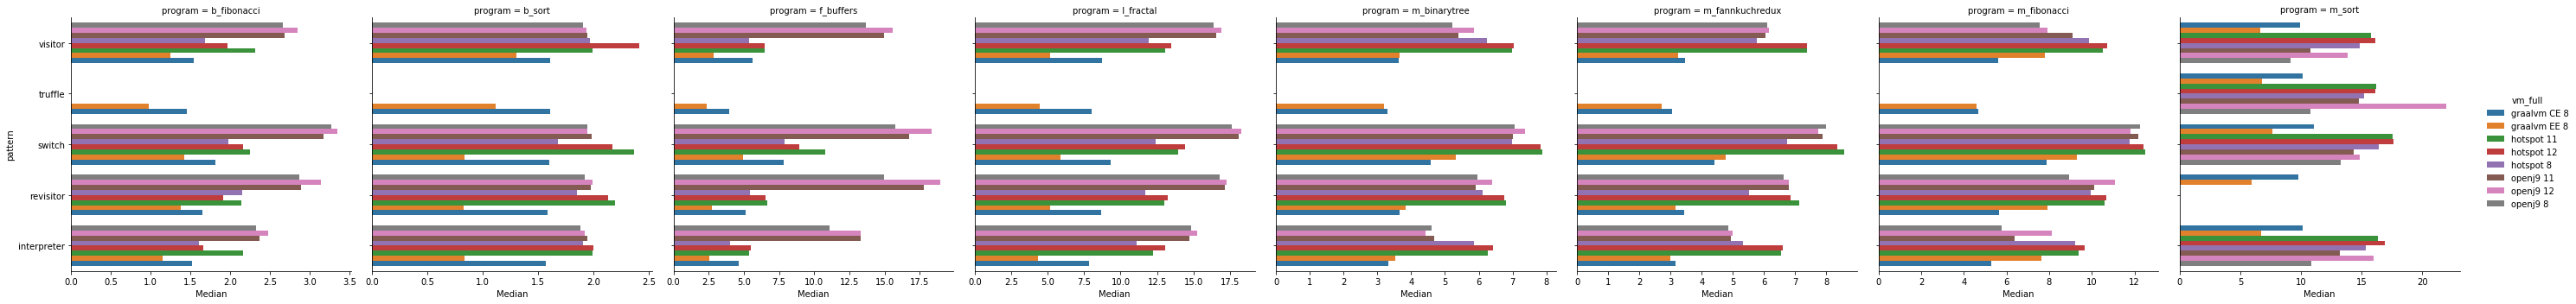

In [101]:
sns.catplot(x="Median", y="pattern", col="program", hue="vm_full", kind="bar", data=medians, sharex=False, legend_out=True)

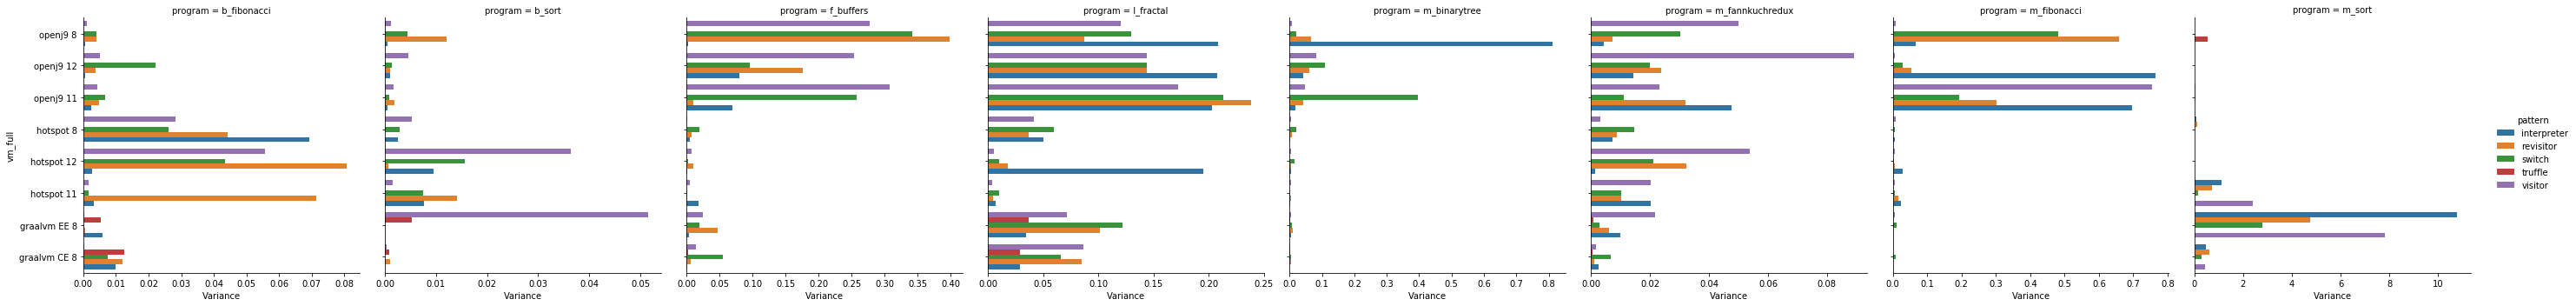

In [102]:
sns.catplot(x="Variance", y="vm_full", col="program", hue="pattern", kind="bar", data=variances, sharex=False, legend_out=True)

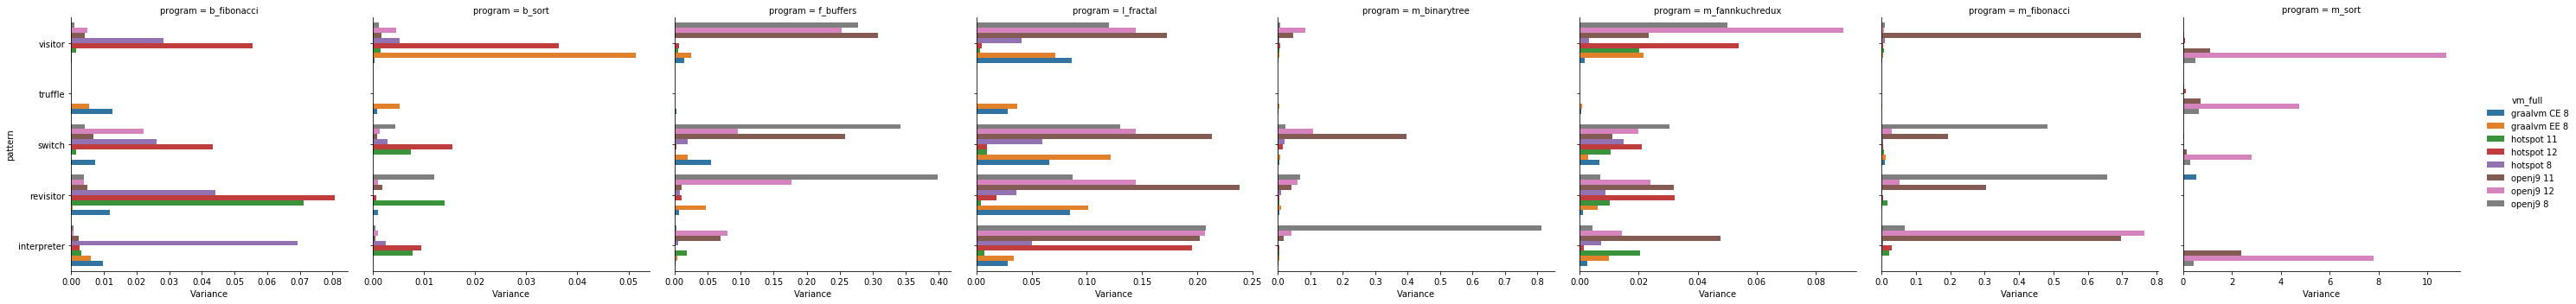

In [103]:
sns.catplot(x="Variance", y="pattern", col="program", hue="vm_full", kind="bar", data=variances, sharex=False, legend_out=True)

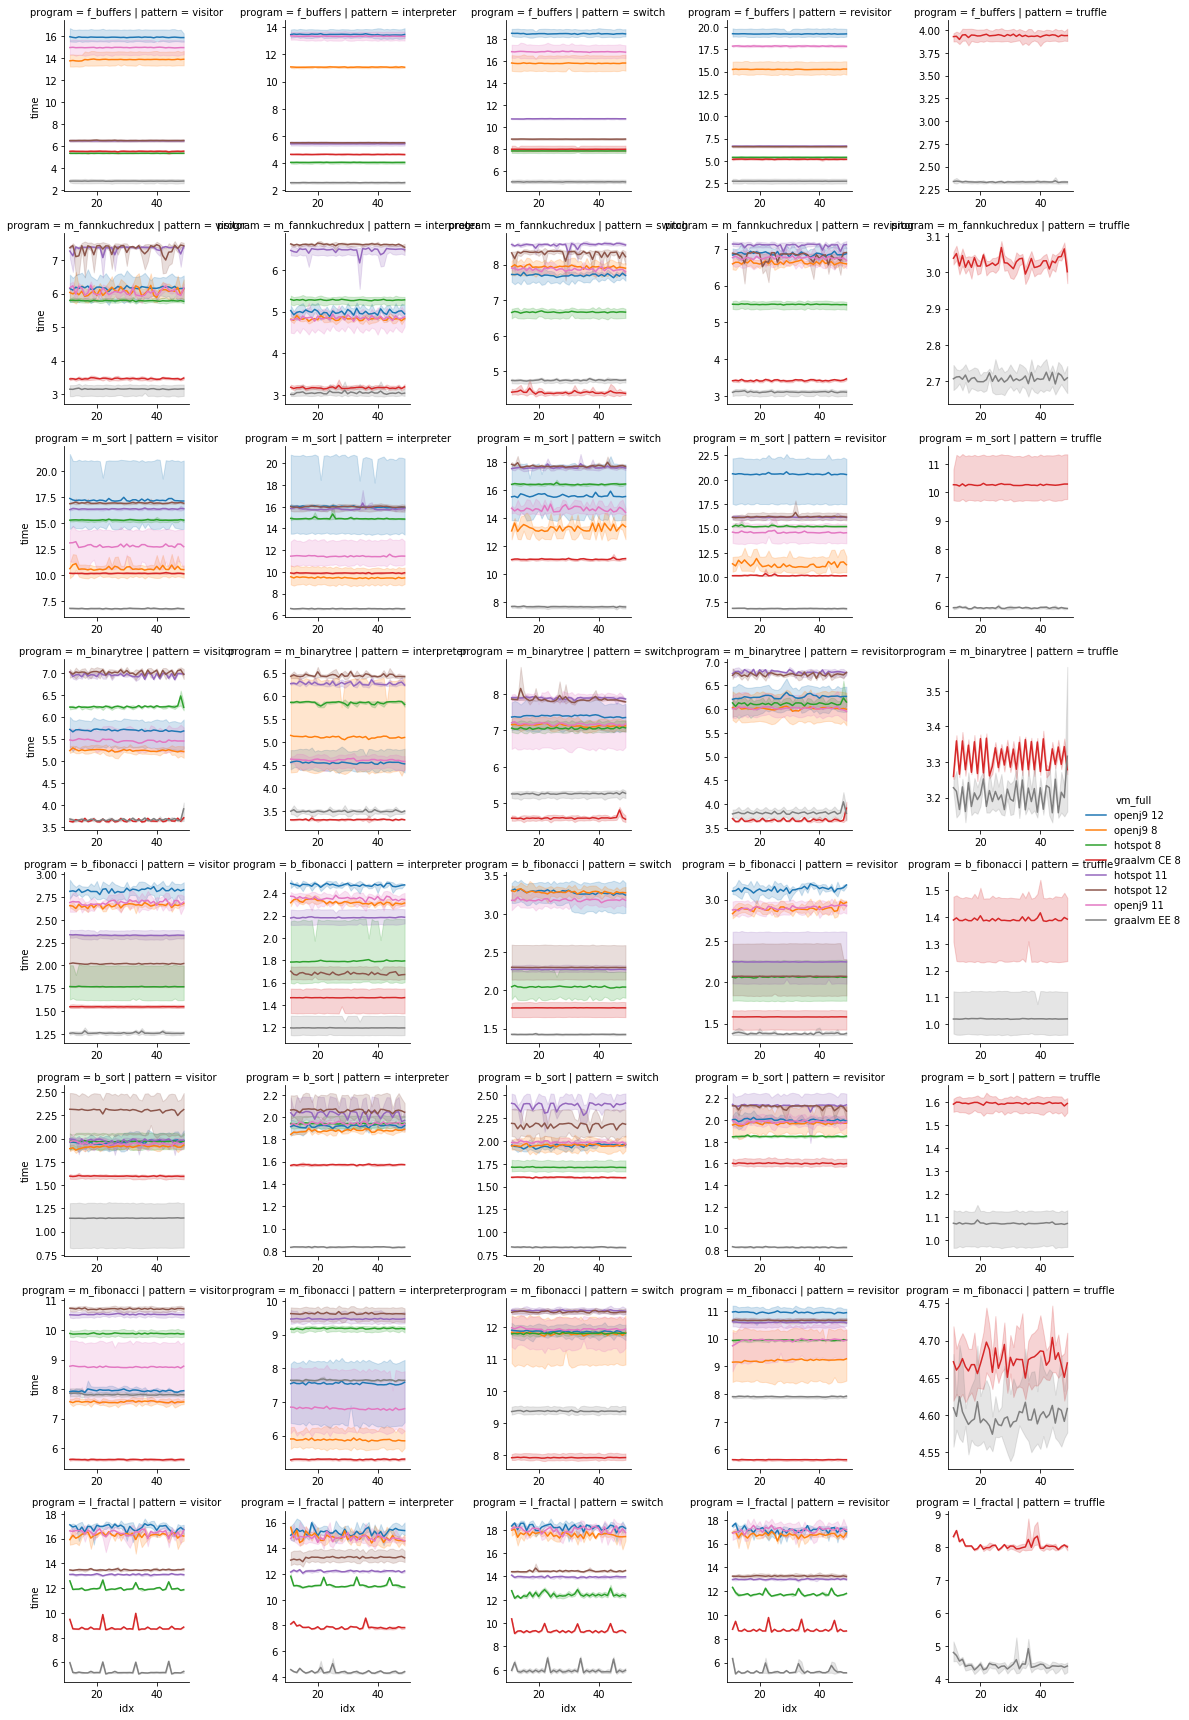

In [104]:
grid = sns.FacetGrid(nwp, col="pattern", row="program", hue="vm_full", sharex=False, sharey=False)
grid.map(sns.lineplot, "idx", "time").add_legend()

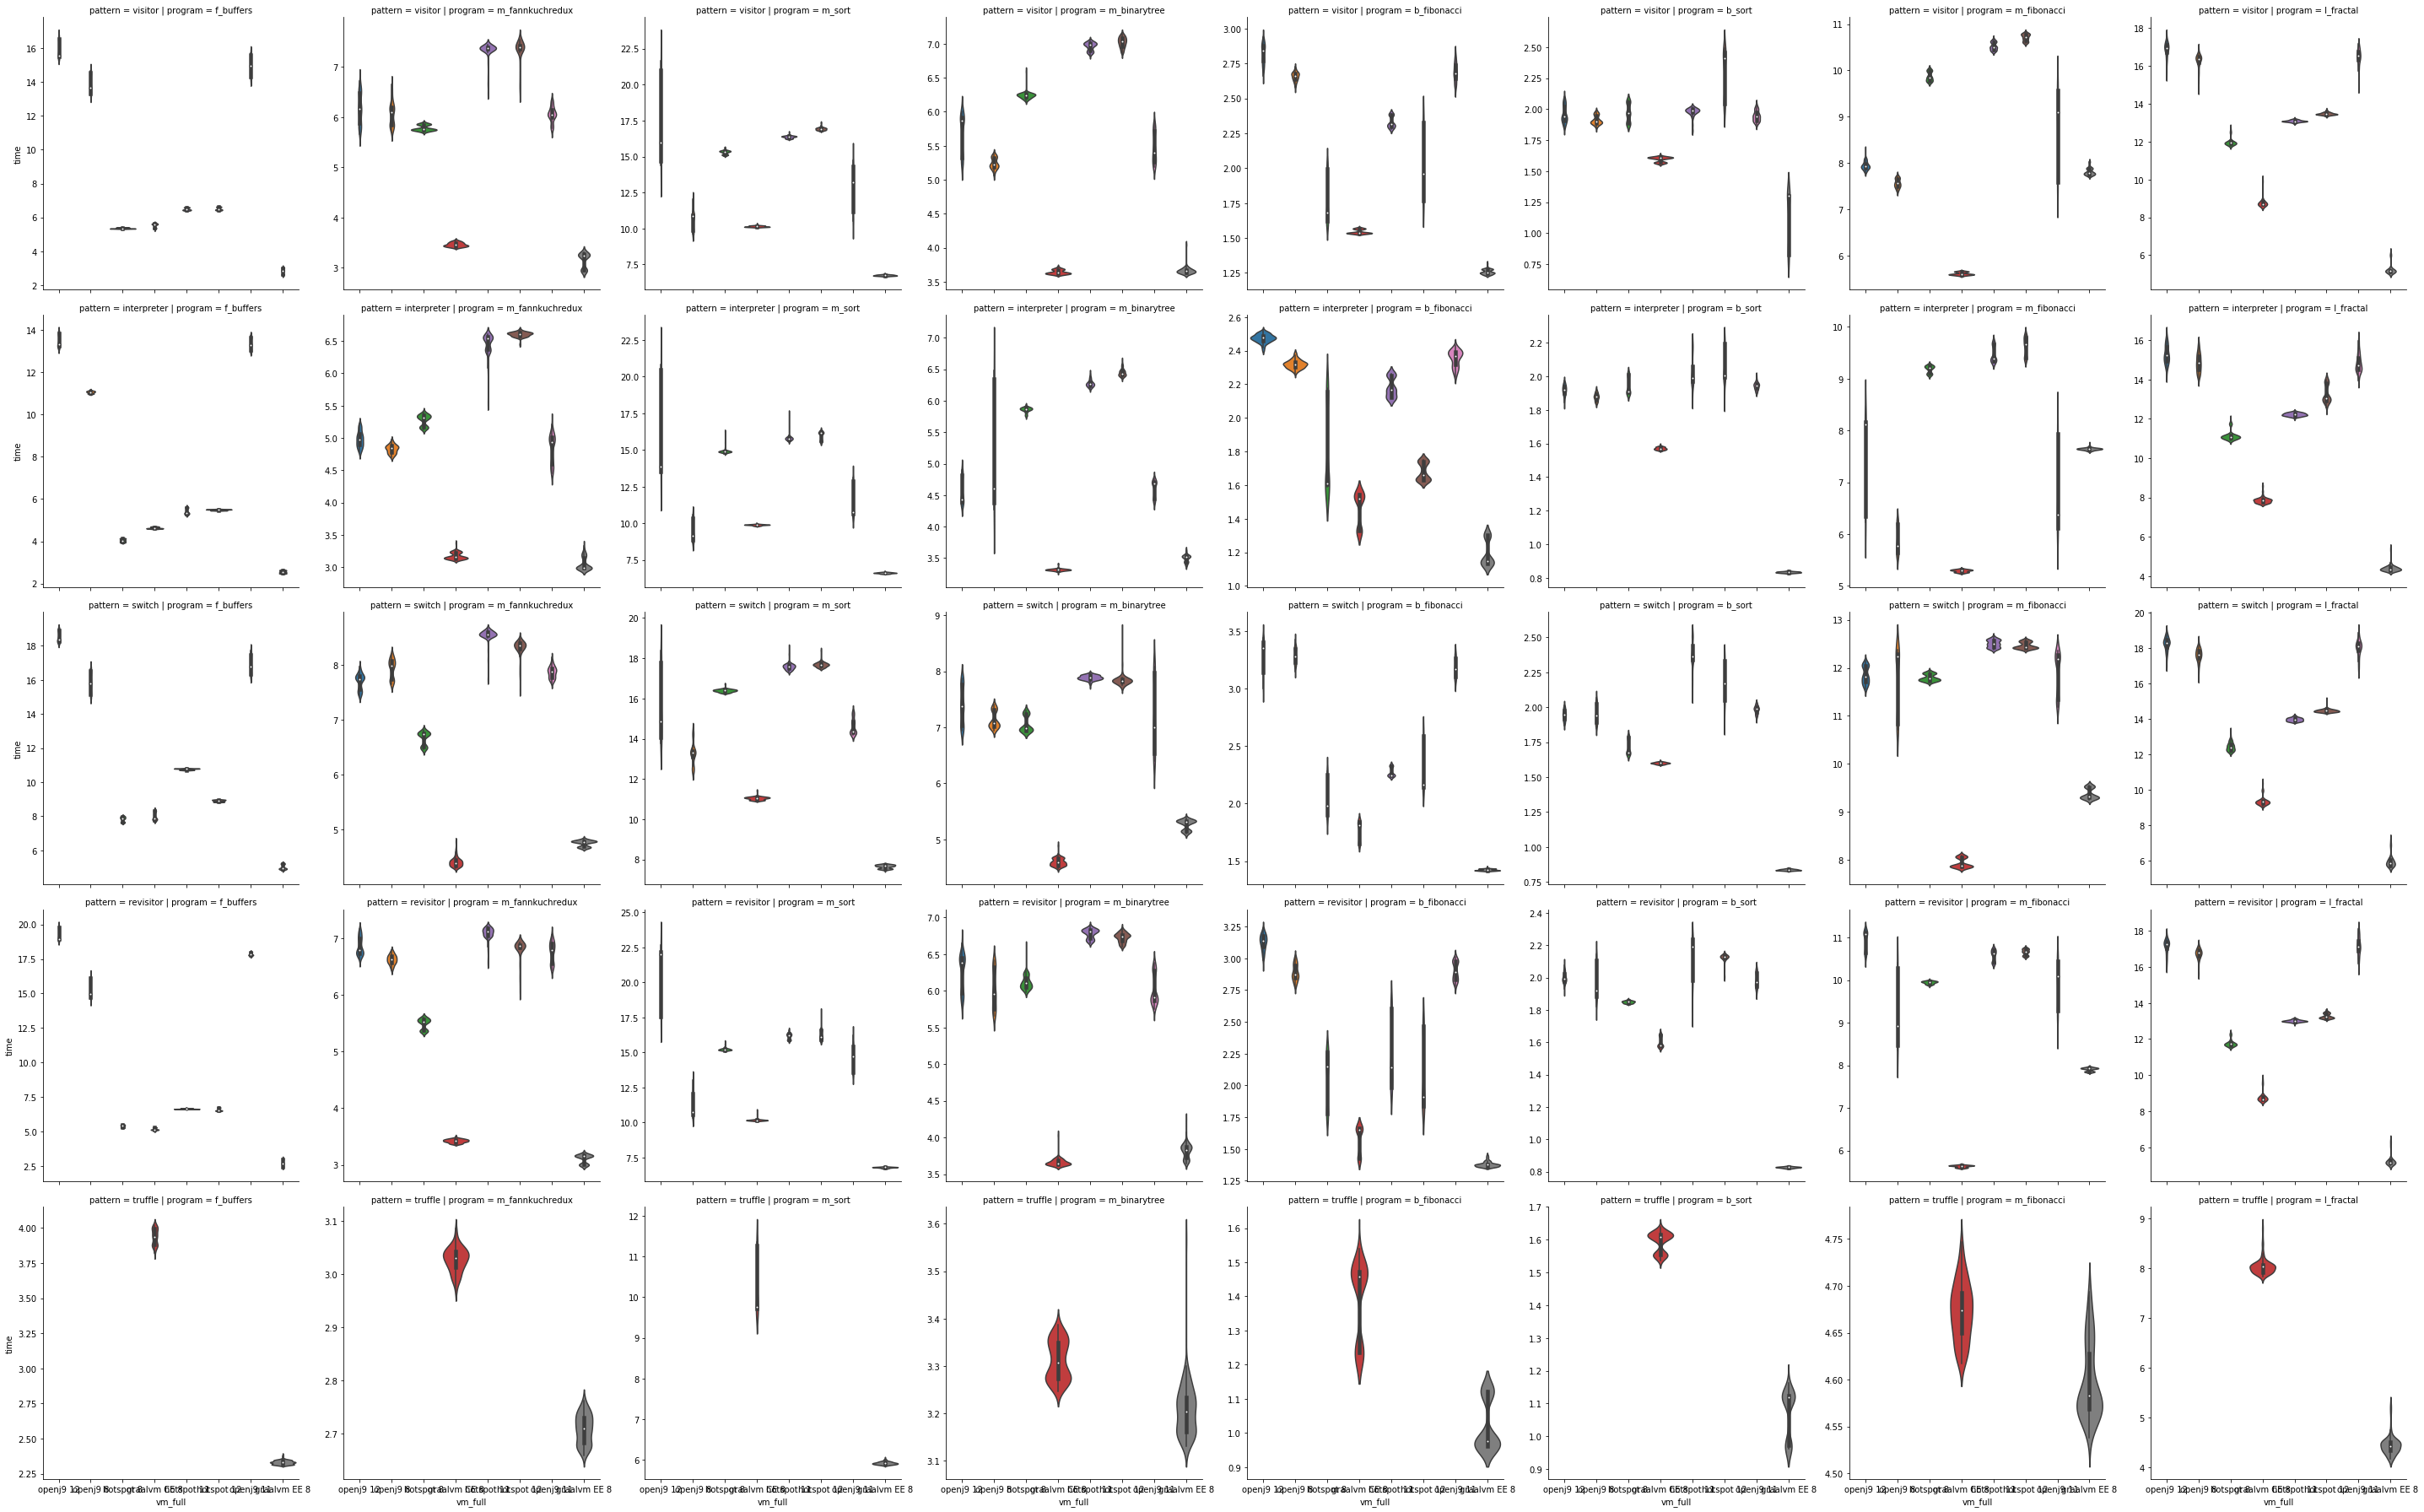

In [105]:
sns.catplot(x="vm_full", y="time", col="program", row="pattern", kind="violin", data=nwp, sharey=False, legend_out=True)

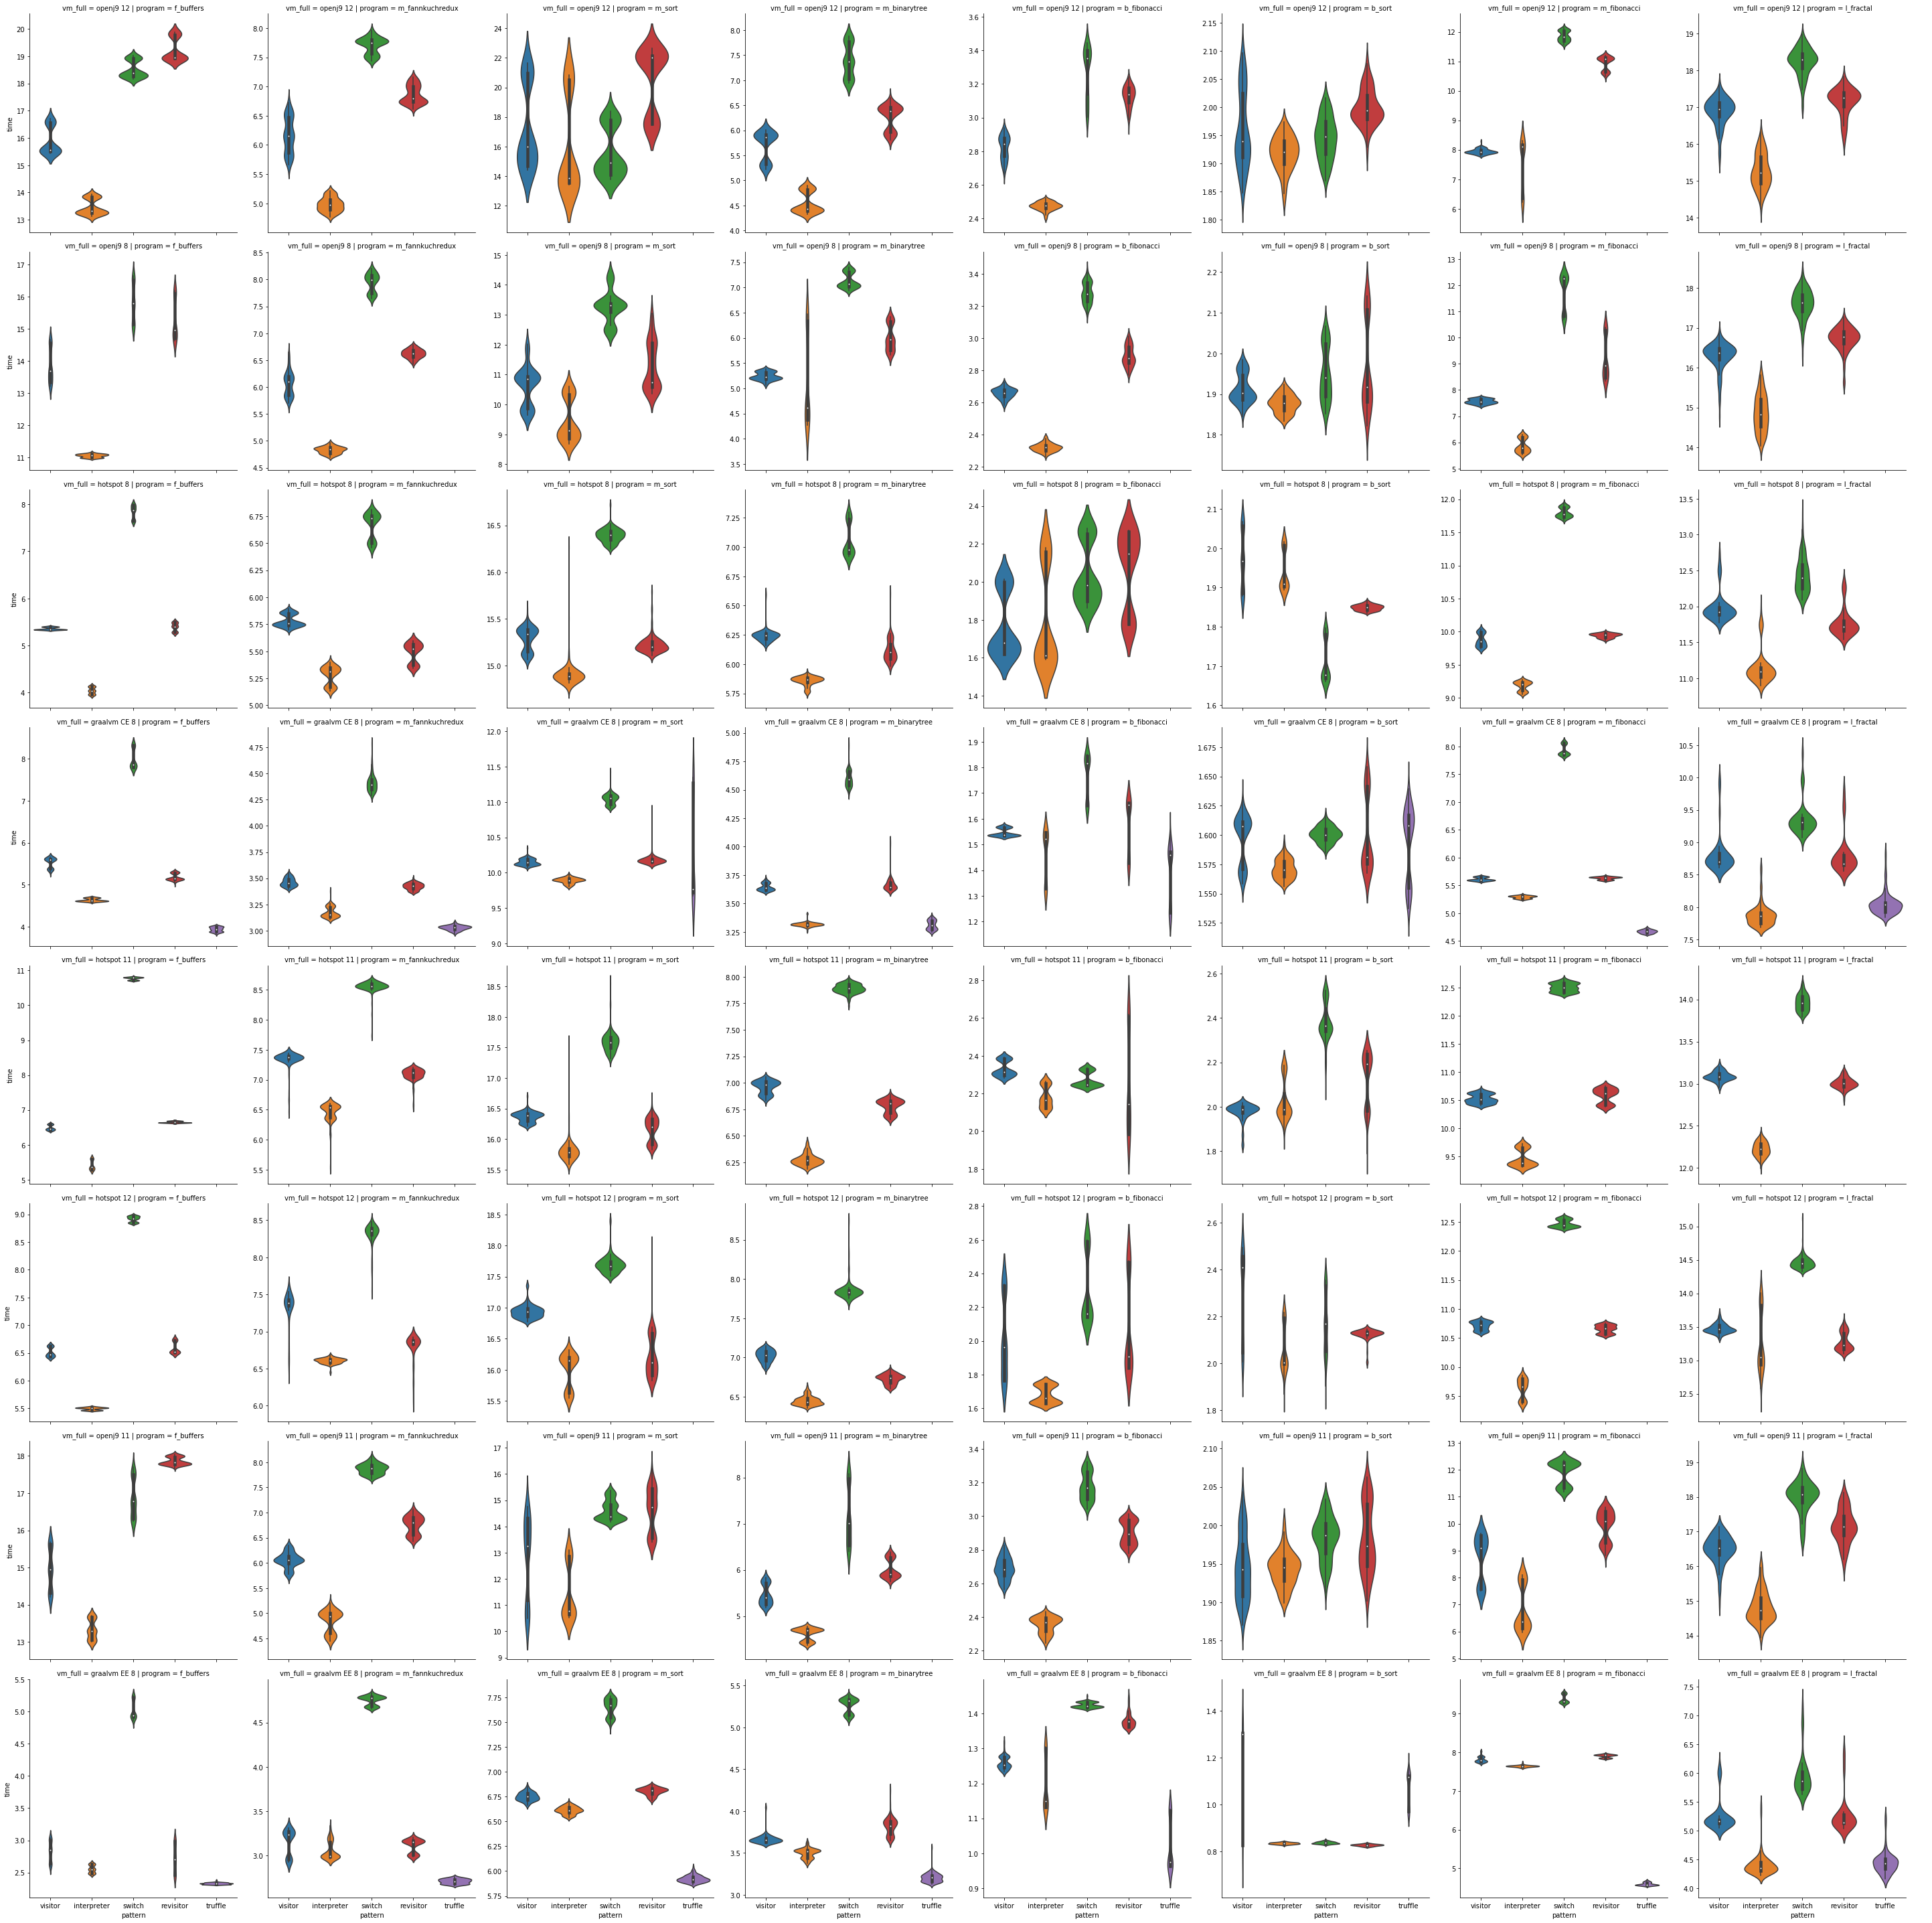

In [106]:
sns.catplot(x="pattern", y="time", col="program", row="vm_full", kind="violin", data=nwp, sharey=False).add_legend()

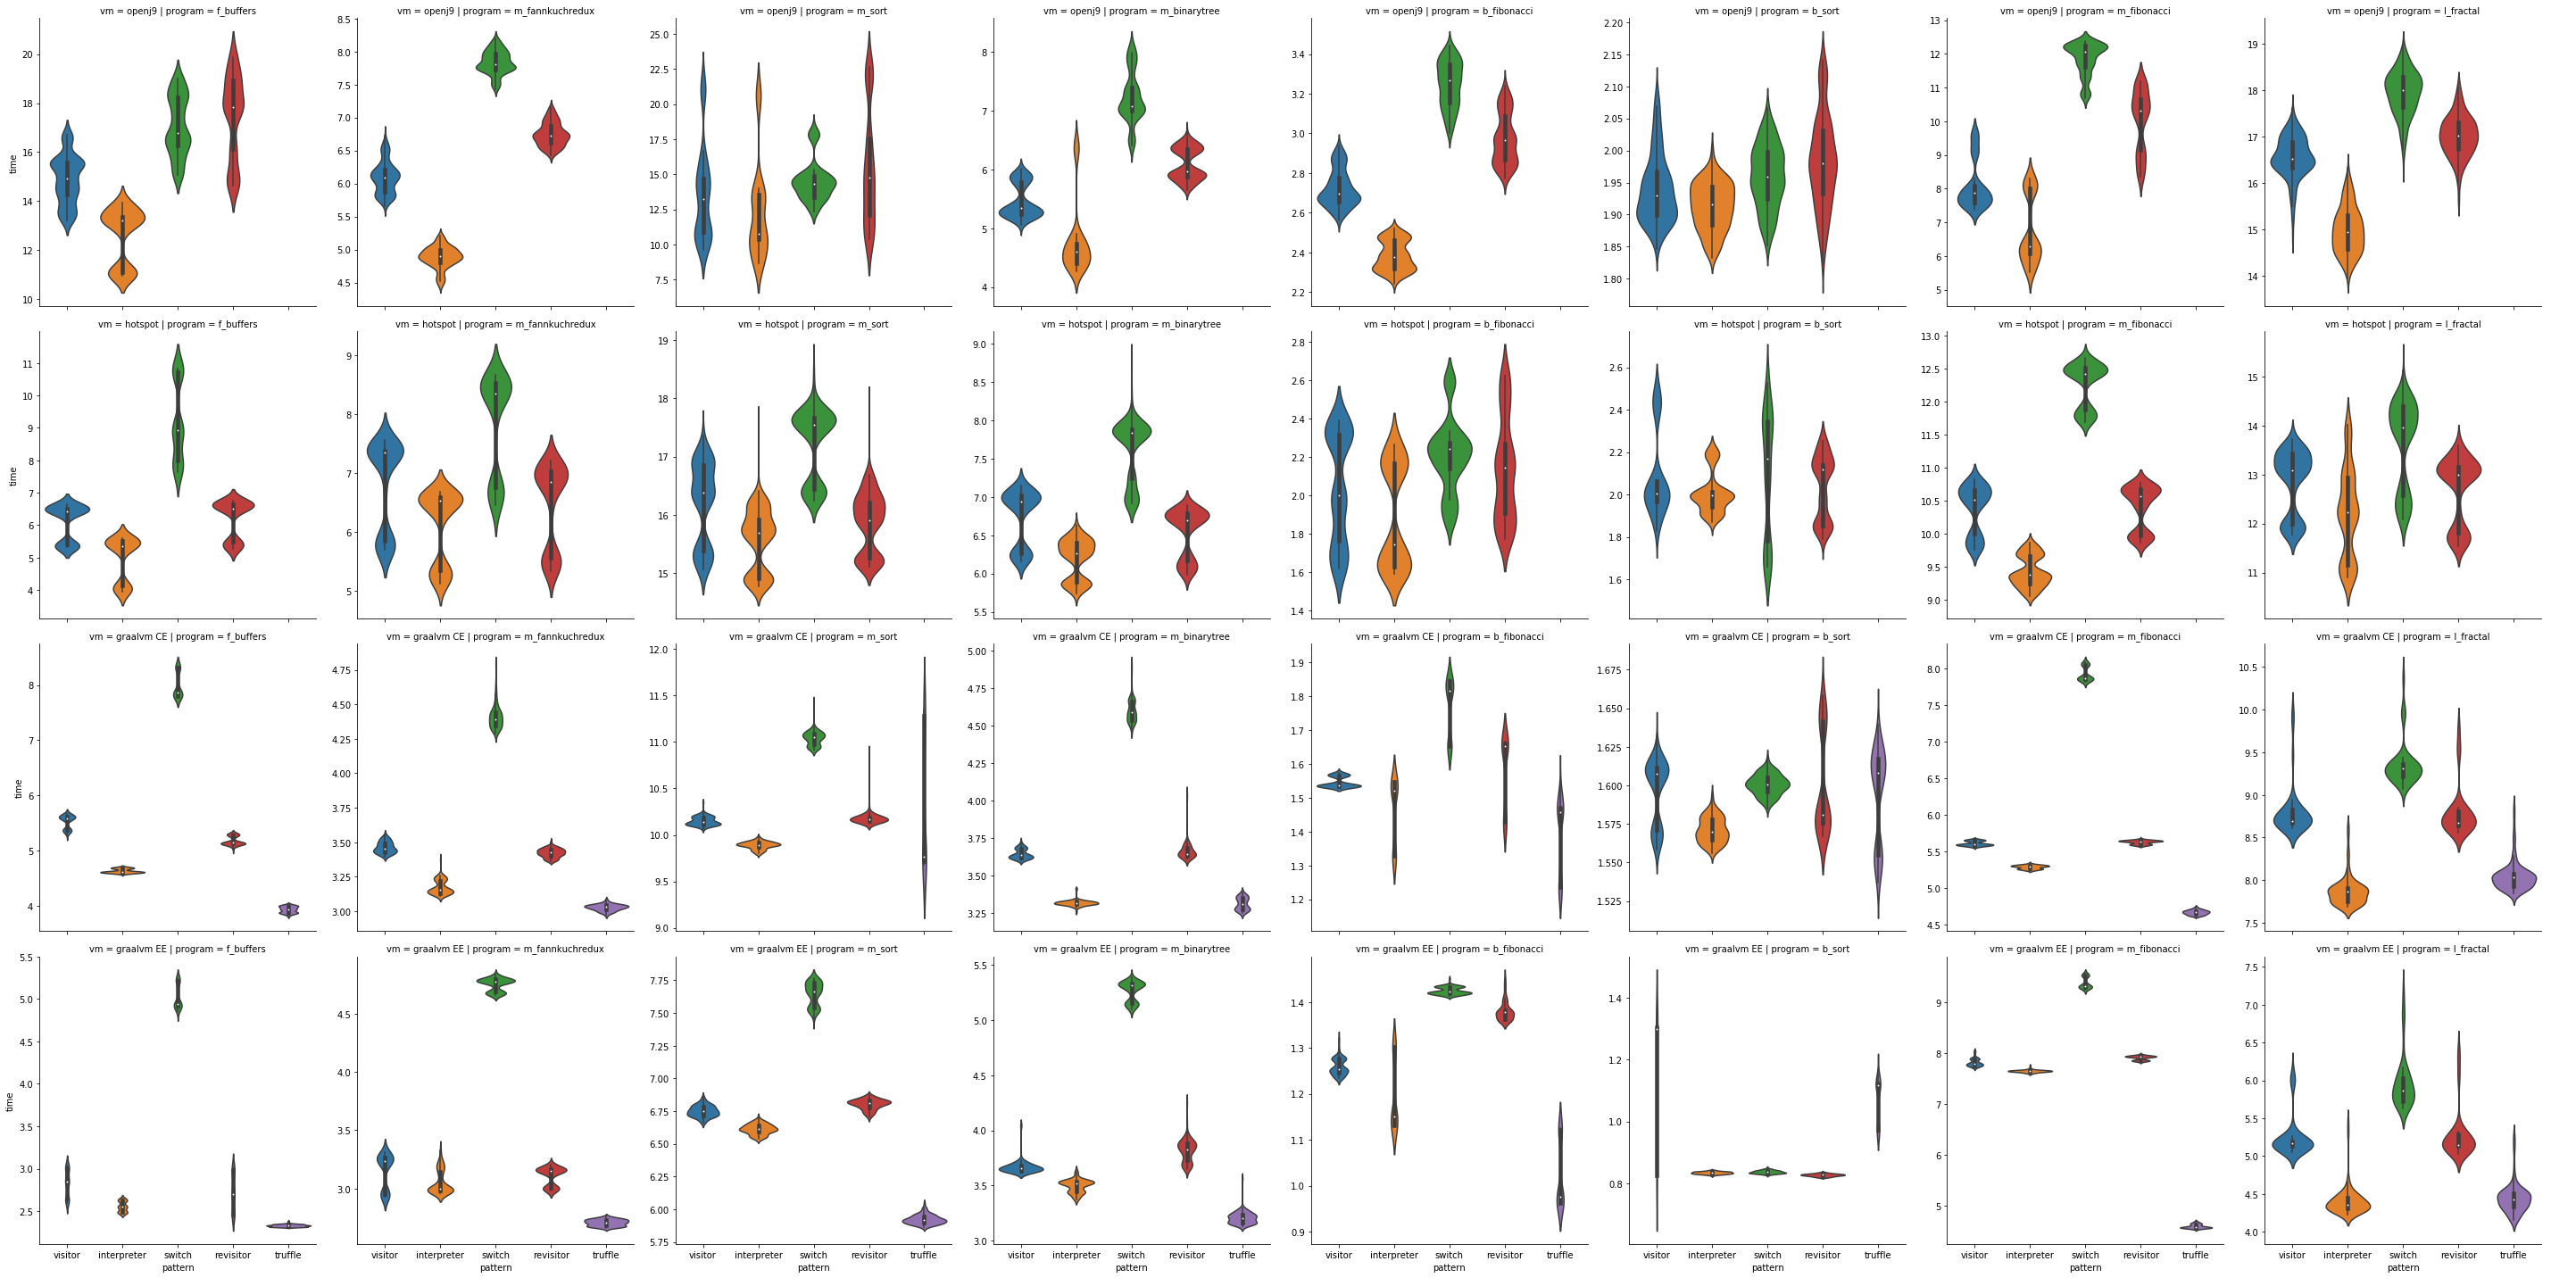

In [107]:
sns.catplot(x="pattern", y="time", col="program", row="vm", kind="violin", data=nwp, sharey=False).add_legend()